In [338]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import gymnasium as gym
import enflow as ef
import treewe as tr

### Step 1) Define the energy system 

In [339]:
dataset = tr.load_dataset('gefcom2014-wind')

In [340]:
portfolio = dataset.collection
portfolio.draw_tree(show_type=True)

Portfolio (edm.Portfolio)
├── Site1 (edm.WindFarm)
├── Site10 (edm.WindFarm)
├── Site2 (edm.WindFarm)
├── Site3 (edm.WindFarm)
├── Site4 (edm.WindFarm)
├── Site5 (edm.WindFarm)
├── Site6 (edm.WindFarm)
├── Site7 (edm.WindFarm)
├── Site8 (edm.WindFarm)
└── Site9 (edm.WindFarm)


In [341]:
dataset.list_data()

['data_gefcom2014_wind', 'scores_gefcom2014_wind']

### Step 2) Define state, exogeneous and action spaces

In [342]:
state_space = ef.DataFrameSpace({asset.name: {
    'U10': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'V10': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'U100': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'V100': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'Power': gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
} for asset in portfolio.assets})

n_quantiles = 99

action_space = ef.DataFrameSpace({asset.name: {
    f"Quantile_forecast_{i+1}": gym.spaces.Box(low=0, high=1, shape=(1,)) for i in range(n_quantiles)
} for asset in portfolio.assets})


In [343]:
state_space.sample(n_rows=5)

Site1                                            Site10            \
      Power       U10      U100       V10      V100     Power       U10   
0  0.383089 -1.860671  0.254469 -0.193022 -0.290154  0.866953 -2.158075   
1  0.346346  1.010392 -0.087940  0.733632  1.791970  0.599869 -0.510734   
2  0.881427 -0.366908  0.342045 -1.046759  1.280826  0.064029  2.501131   
3  0.133070  0.068084 -0.032891 -1.210668 -0.539143  0.380786  0.294341   
4  0.826930  1.925988  0.437919  1.711777 -0.049622  0.893661 -1.265492   

                                 ...     Site8                                \
       U100       V10      V100  ...     Power       U10      U100       V10   
0  1.153403  1.427405  2.449460  ...  0.620598 -0.861717  0.041175 -0.931074   
1 -1.110711  1.130575  0.557217  ...  0.877588 -0.650961  0.832693  1.197210   
2  1.538831 -0.574330 -0.509561  ...  0.880097  0.825711  0.267374  2.246004   
3 -0.918359 -0.622999  0.570892  ...  0.998827 -0.042568  0.266281  0.192303   
4 -0.264256  0.351677  0.881875  ...  0.066178  0.040481 -0.633039 -0.469893   

                Site9                                          
       V100     Power       U10      U100       V10      V100  
0  0.793876  0.425900  0.674183  0.700931 -0.257396 -1.206773  
1  1.114502  0.281295 -0.481349 -0.677523 -0.106803  0.753115  
2  0.730862  0.797354  0.275688 -1.600485 -0.407280 -0.449768  
3 -0.169987  0.110853 -0.715208 -0.904895 -0.039267  0.847779  
4 -1.144282  0.307449 -0.414353  0.070163  1.314304 -1.353649  

[5 rows x 50 columns]

In [344]:
action_space.sample(n_rows=3)

Site1                                            \
  Quantile_forecast_1 Quantile_forecast_10 Quantile_forecast_11   
0            0.091679             0.801759             0.443812   
1            0.519758             0.571765             0.121889   
2            0.537022             0.384573             0.873745   

                                                                  \
  Quantile_forecast_12 Quantile_forecast_13 Quantile_forecast_14   
0             0.612667             0.477293             0.154923   
1             0.367075             0.660412             0.042366   
2             0.551569             0.501055             0.002324   

                                                                  \
  Quantile_forecast_15 Quantile_forecast_16 Quantile_forecast_17   
0             0.999382             0.215847             0.685102   
1             0.162214             0.957048             0.347346   
2             0.448211             0.343534             0.882150   

                        ...                Site9                       \
  Quantile_forecast_18  ... Quantile_forecast_90 Quantile_forecast_91   
0             0.771936  ...             0.181803             0.756722   
1             0.545733  ...             0.429631             0.503821   
2             0.119904  ...             0.004577             0.155635   

                                                                  \
  Quantile_forecast_92 Quantile_forecast_93 Quantile_forecast_94   
0             0.809476             0.787910             0.028462   
1             0.082361             0.951802             0.331606   
2             0.426663             0.314528             0.360103   

                                                                  \
  Quantile_forecast_95 Quantile_forecast_96 Quantile_forecast_97   
0             0.187857             0.477830             0.991554   
1             0.952995             0.395107             0.619315   
2             0.341251             0.099851             0.746440   

                                             
  Quantile_forecast_98 Quantile_forecast_99  
0             0.088172             0.436683  
1             0.700554             0.418856  
2             0.405744             0.684326  

[3 rows x 990 columns]

### Step 3) Create environment

In [345]:

dataset.data["data_gefcom2014_wind"].index[0][1]

Timestamp('2012-01-01 01:00:00')

In [346]:
class GEFCom2014WindEnv(gym.Env):
    def __init__(self, dataset: ef.Dataset, test_month, n_training_months): 
        self.dataset = dataset
        self.data = dataset.data["data_gefcom2014_wind"]
        self.scores = dataset.data["scores_gefcom2014_wind"]
        self.input = ["U10", "V10", "U100", "V100"]
        self.target = ["Power"]
        self.state_space = state_space
        self.action_space = action_space
        self.test_month = test_month
        self.n_training_months = n_training_months
        self.idx_counter = 0

        self._generate_train_test()
        self.n_steps = len(self.test)

    def _generate_train_test(self):
        self.train = []
        self.test = []
        test_start = pd.to_datetime(self.test_month + "-01") + pd.DateOffset(hours=1)
        test_end = test_start + pd.DateOffset(months=1) - pd.DateOffset(hours=1)
        train_end = test_start - pd.DateOffset(hours=1)
        for n in range(1, self.n_training_months+1): 
            train_start = train_end - pd.DateOffset(months=n) + pd.DateOffset(hours=1)
            if train_start < self.data.index[0][1]:
                break
            self.train.append([train_start, train_end])
            self.test.append([test_start, test_end])

    def reset(self, return_dataframe=False):
        self.idx_counter = 0
        training_data = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.train[self.idx_counter][0]) &
                                      (self.data.index.get_level_values('valid_datetime') <= self.train[self.idx_counter][1])]

        first_input = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.test[self.idx_counter][0]) &
                                    (self.data.index.get_level_values('valid_datetime') <= self.test[self.idx_counter][1]),
                                     pd.IndexSlice[:, self.input]]

        return first_input, training_data

    def step(self, action=None):
        self.idx_counter += 1

        if self.idx_counter < self.n_steps:
            next_input = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.test[self.idx_counter][0]) &
                                    (self.data.index.get_level_values('valid_datetime') <= self.test[self.idx_counter][1]),
                                        pd.IndexSlice[:, self.input]] 
            
            previous_target = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.test[self.idx_counter-1][0]) &
                                        (self.data.index.get_level_values('valid_datetime') <= self.test[self.idx_counter-1][1]),
                                            pd.IndexSlice[:, self.target]]
            
            training_data = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.train[self.idx_counter][0]) &
                                        (self.data.index.get_level_values('valid_datetime') <= self.train[self.idx_counter][1])]
            
            done = False
        
        elif self.idx_counter == self.n_steps:
            previous_target = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.test[self.idx_counter-1][0]) &
                                        (self.data.index.get_level_values('valid_datetime') <= self.test[self.idx_counter-1][1]),
                                            pd.IndexSlice[:, self.target]]
            
            training_data = None
            next_input = None
            done = True
        
        return next_input, previous_target, training_data, done
        
    def plot_results(self, losses, drop_tasks=None, n_top_teams=None, xlim=None):
        df_scores = self.scores
        df_scores = df_scores.assign(**losses)
        df_scores = df_scores.drop(index=drop_tasks)
        df_scores.loc["Overall"] = df_scores.mean()
        teams = list(df_scores.drop(columns=losses.keys()).loc["Overall",:].sort_values().iloc[:n_top_teams].index.values)
        teams.extend(losses.keys())
        ax = df_scores.loc[::-1,teams].plot.barh(title="Pinball loss GEFCom20214")
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        if xlim: ax.set_xlim(0, xlim)

        return ax

    def plot_forecasts(self, training_target, df_predictions, site="Site1"): 
        import pandas as pd
        import plotly.graph_objects as go
        df = df_predictions.droplevel(0).loc[:,"Site1"]
        df_target = training_target.loc[df.index[0]:df.index[-1],:].droplevel(0).loc[:,"Site1"]

        # Sort quantiles to ensure outer quantiles are filled first
        quantile_columns = [col for col in df.columns if col.startswith('quantile')]
        quantile_columns.sort(key=lambda x: float(x.split('_')[1]))

        # Create the figure
        fig = go.Figure()

        # Loop over the quantiles and add shaded areas
        # Start from the outermost quantiles and move inward
        for i in range(len(quantile_columns) // 2):
            upper_quantile = quantile_columns[-(i+1)]
            lower_quantile = quantile_columns[i]
            
            # Add the upper quantile line (invisible)
            fig.add_trace(go.Scatter(
                x=df.index,
                y=df[upper_quantile],
                mode='lines',
                line=dict(color='rgb(0, 0, 255)', width=0),  # No line for the upper bound
                fill=None,
                showlegend=False,
                hoverinfo='skip',  # This disables the hover tooltip
                name=f'{upper_quantile}'
            ))
            
            # Add the lower quantile line and fill the area between the two traces
            fig.add_trace(go.Scatter(
                x=df.index,
                y=df[lower_quantile],
                mode='lines',
                line=dict(width=0),  # No line for the lower bound
                fill='tonexty',  # Fill between this trace and the previous one
                fillcolor=f'rgba(0, 0, 255, {0.1 + i * 0.1})',  # Increasing opacity for each quantile band
                showlegend=False,
                hoverinfo='skip',  # This disables the hover tooltip
                name=f'{lower_quantile}'
            ))

        fig.add_trace(go.Scatter(
            x=df.index,
            y=df["quantile_50"],
            mode='lines',
            line=dict(color='blue', width=1),  # Central forecast line
            showlegend=False,
            name='Median'
        ))

        fig.add_trace(go.Scatter(
            x=df_target.index,
            y=df_target["Power"],
            mode='lines',
            line=dict(color='rgba(200, 0, 0, 0.5)', width=2),  # Central forecast line
            showlegend=False,
            name='Power'
        ))

        # Customize layout
        fig.update_layout(
            title='GEFCom2014 Wind Power Forecast',
            xaxis_title='Time',
            yaxis_title='Value',
            hovermode="x"
        )

        # Add range slider
        fig.update_layout(
            xaxis=dict(
                rangeslider=dict(
                    visible=True
                ),
                type="date"
            )
        )

        # Show the plot
        fig.show()


### Step 4) Define the objective


In [347]:
from enflow.problems.objective import PinballLoss

obj = PinballLoss(quantiles=[0.1, 0.5, 0.9])

### Step 5) Create the model


In [348]:
import lightgbm as lgb
import pandas as pd
from contextlib import nullcontext

class LGBGEFCom2014Predictor(ef.Predictor):
    def __init__(self, name=None, quantiles=None):
        """
        Initialize the Predictor class.
        
        Args:
            quantiles (list): List of quantiles for which to create separate models.
                              Example: [0.1, 0.5, 0.9]
        """
        self.name = name
        self.models = {}  # Dictionary to hold models for each site and quantile
        self.quantiles = quantiles
        
    def train(self, features: pd.DataFrame, target: pd.DataFrame, show_progress=True, **kwargs):
        """
        Train separate LightGBM models for each site and quantile.
        
        Args:
            features (pd.DataFrame): Multi-indexed dataframe where the top-level index corresponds to sites.
            target (pd.DataFrame): The target dataframe (y), also multi-indexed by site.
            kwargs: Additional parameters to pass to the LightGBMRegressor model.
        """
        # Get the list of unique sites from the multi-index (top level)
        sites = features.columns.get_level_values(0).unique()
        feature_names = features.columns.get_level_values(1).unique()

        pbar = tqdm(total=len(sites)*len(self.quantiles), mininterval=0, desc=f"Training {self.name}") if show_progress else nullcontext()

        with pbar as progress: 
            # Loop over each site
            for site in sites:
                # Extract the features and target for the current site
                site_features = features.xs(site, axis=1, level=0)
                site_target = target.xs(site, axis=1, level=0)

                # Loop over each quantile
                for quantile in self.quantiles:
                    # Initialize a LightGBM model for this quantile
                    params = {'objective': 'quantile', 'alpha': quantile, "verbose": -1}
                    params.update(kwargs)  # Add any additional LightGBM parameters
                    
                    model = lgb.LGBMRegressor(**params)
                    
                    # Train the model on the site's data
                    model.fit(site_features, site_target)
                    
                    # Store the trained model with a key (site, quantile)
                    self.models[(site, quantile)] = model
                    
                    if show_progress: 
                        progress.update(1)

    def predict(self, features: pd.DataFrame):
        """
        Make predictions for a specific site and quantile using the trained model.
        
        Args:
            features (pd.DataFrame): The feature dataframe (X), multi-indexed by site.
            site (str): The site for which to make predictions.
            quantile (float): The quantile for which to make predictions.
        
        Returns:
            np.array: Predictions from the model.
        """

        # Create a nested dictionary to store predictions
        predictions = {}

        # Extract the features for the specific site
        sites = features.columns.get_level_values(0).unique()

        # Loop over each site and quantile
        for site in sites:
            # Extract the features for the current site
            site_features = features.xs(site, axis=1, level=0)

            # Initialize an inner dictionary for each site

            for quantile in self.quantiles:
                # Check if the model for the given site and quantile exists
                if (site, quantile) not in self.models:
                    raise ValueError(f"No trained model for site '{site}' and quantile '{quantile}'.")

                # Make predictions using the stored model
                model = self.models[(site, quantile)]
                site_predictions = model.predict(site_features)

                # Store the predictions under the quantile for the current site
                predictions[(site, f"quantile_{round(100*quantile)}")] = site_predictions

        # Convert the nested dictionary to a DataFrame with multi-index columns
        predictions = pd.DataFrame.from_dict(predictions)
        predictions.index = features.index
        
        return predictions


### Step 6) Run the sequential decision loop and evaluate performance

In [349]:
training_data.head(3)

AttributeError: 'NoneType' object has no attribute 'head'

In [317]:
training_data.head(3)

Site1                      \
                                            Power       U10      U100   
ref_datetime        valid_datetime                                      
2012-12-01 01:00:00 2012-12-01 01:00:00  0.469129  4.535272  6.153654   
                    2012-12-01 02:00:00  0.434452  5.109273  6.976518   
                    2012-12-01 03:00:00  0.542524  5.195243  7.111877   

                                                                Site2  \
                                              V10      V100     Power   
ref_datetime        valid_datetime                                      
2012-12-01 01:00:00 2012-12-01 01:00:00 -0.530983 -0.795114  0.180398   
                    2012-12-01 02:00:00 -0.810788 -1.220416  0.220262   
                    2012-12-01 03:00:00 -0.616104 -0.941958  0.304374   

                                                                       \
                                              U10      U100       V10   
ref_datetime        valid_datetime                                      
2012-12-01 01:00:00 2012-12-01 01:00:00  3.222741  4.081398  1.415866   
                    2012-12-01 02:00:00  3.652593  4.610660  1.186260   
                    2012-12-01 03:00:00  4.292554  5.481242  2.377941   

                                                   ...     Site9            \
                                             V100  ...     Power       U10   
ref_datetime        valid_datetime                 ...                       
2012-12-01 01:00:00 2012-12-01 01:00:00  1.746907  ...  0.331955  4.494140   
                    2012-12-01 02:00:00  1.460291  ...  0.306241  5.073699   
                    2012-12-01 03:00:00  2.973321  ...  0.374725  5.316417   

                                                                       \
                                             U100       V10      V100   
ref_datetime        valid_datetime                                      
2012-12-01 01:00:00 2012-12-01 01:00:00  6.149758 -0.201852 -0.388848   
                    2012-12-01 02:00:00  6.972623 -0.654517 -1.028976   
                    2012-12-01 03:00:00  7.326114 -0.526182 -0.870167   

                                           Site10                      \
                                            Power       U10      U100   
ref_datetime        valid_datetime                                      
2012-12-01 01:00:00 2012-12-01 01:00:00  0.031119  2.926291  3.572585   
                    2012-12-01 02:00:00  0.029213  4.307747  5.330789   
                    2012-12-01 03:00:00  0.065861  4.310341  5.378505   

                                                             
                                              V10      V100  
ref_datetime        valid_datetime                           
2012-12-01 01:00:00 2012-12-01 01:00:00  1.274872  1.719714  
                    2012-12-01 02:00:00  1.114235  1.610397  
                    2012-12-01 03:00:00  1.087608  1.629432  

[3 rows x 50 columns]

In [423]:
n_test_months = 12
n_training_months = 12

losses_i = []
obj = PinballLoss(quantiles=[0.5])
if "pbar" in globals(): pbar.close();
pbar = tqdm(total=n_test_months*n_training_months, mininterval=0, leave=False)
for i in range(1,n_test_months+1): 
    env = GEFCom2014WindEnv(dataset=dataset, test_month=f"2013-{i:02}", n_training_months=n_training_months)
    next_input, training_data = env.reset()
    model = LGBGEFCom2014Predictor(name="predictor", quantiles=[0.5])

    losses_j = []
    for j in range(env.n_steps):
        pbar.set_description(f"Test month: 2013-{i:02}. Training months: {j+1}.")

        training_input = training_data.loc[:,(slice(None), env.input)]
        training_target = training_data.loc[:,(slice(None), env.target)]
        model.train(features=training_input, target=training_target, show_progress=False)
        prediction = model.predict(features=next_input)
        next_input, previous_target, training_data, done = env.step()

        loss = obj.calculate(previous_target, prediction, mean=False)
        losses_j.append(np.nanmean(loss, axis=(0,2)))

        pbar.update(1)

    losses_i.append(np.stack(losses_j, axis=-1))
    
losses = np.stack(losses_i, axis=-1)

Test month: 2013-12. Training months: 12.: 100%|██████████| 144/144 [04:09<00:00,  1.85s/it]

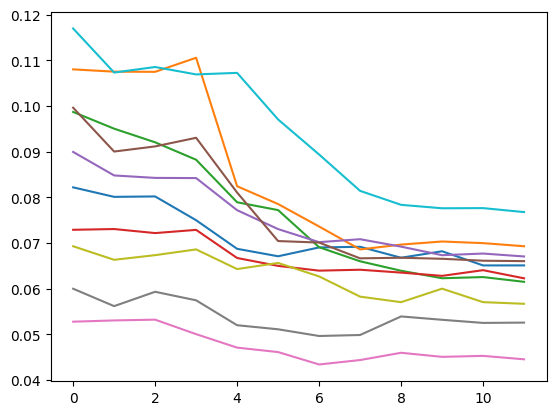

In [337]:
plt.plot(losses[:,:,10].T);

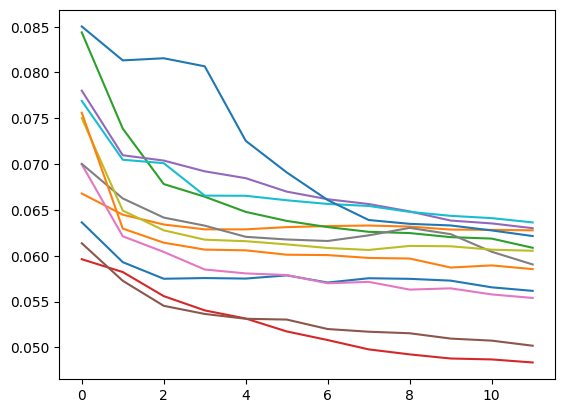

In [327]:
plt.plot(losses.mean(axis=0));

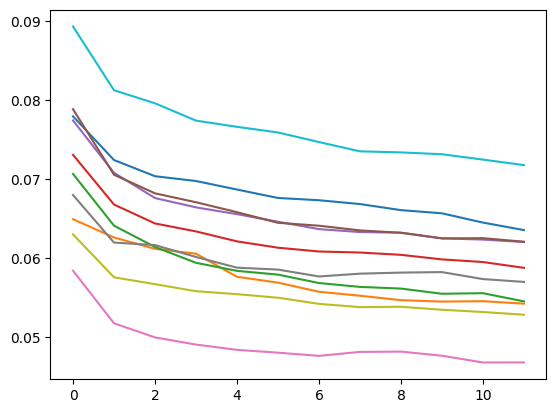

In [307]:
plt.plot(losses.mean(axis=2).T);

In [ ]:
# Make this on loop and train every time. 
losses = {model.name: []}
for i in range(env.n_steps):
    training_input = training_data.loc[:,(slice(None), env.input)]
    training_target = training_data.loc[:,(slice(None), env.target)]
    model.train(features=training_input, target=training_target)
    prediction = model.predict(features=next_input)
    next_input, previous_target, training_data, done = env.step()

    loss = obj.calculate(previous_target, prediction, mean=False)
    losses[model.name].append(loss)

    print(f"{model.name} {obj.name} for step {i+1}: {np.nanmean(loss)}")


Training predictor: 100%|██████████| 30/30 [00:03<00:00,  8.49it/s]


predictor PinballLoss for step 1: 0.05141221210652591


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  7.38it/s]


predictor PinballLoss for step 2: 0.042753599167859604


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  7.10it/s]


predictor PinballLoss for step 3: 0.040975470927086054


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  7.13it/s]


predictor PinballLoss for step 4: 0.04038614904987022


Training predictor: 100%|██████████| 30/30 [00:03<00:00,  8.51it/s]


predictor PinballLoss for step 5: 0.040221574835093095


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  6.70it/s]


predictor PinballLoss for step 6: 0.039898794760407634


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  7.01it/s]


predictor PinballLoss for step 7: 0.0396999585750522


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  6.93it/s]


predictor PinballLoss for step 8: 0.03941674330799964


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  6.57it/s]


predictor PinballLoss for step 9: 0.0391680652205825


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  7.43it/s]


predictor PinballLoss for step 10: 0.03857504369737824


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  7.49it/s]


predictor PinballLoss for step 11: 0.03853656335197426


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  6.82it/s]


predictor PinballLoss for step 12: 0.03817105887063379


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  7.17it/s]


predictor PinballLoss for step 13: 0.03816496652494978


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  6.50it/s]


predictor PinballLoss for step 14: 0.037881083976395905


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


predictor PinballLoss for step 15: 0.03765601367199825


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  6.28it/s]


predictor PinballLoss for step 16: 0.037688760029820245


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  6.82it/s]


predictor PinballLoss for step 17: 0.037783022475934944


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  6.23it/s]


predictor PinballLoss for step 18: 0.03789374082722228


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  6.15it/s]


predictor PinballLoss for step 19: 0.037873775916350834


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  6.85it/s]


predictor PinballLoss for step 20: 0.037777252182386145


Training predictor: 100%|██████████| 30/30 [00:05<00:00,  5.93it/s]


predictor PinballLoss for step 21: 0.03791941434656734


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  6.85it/s]


predictor PinballLoss for step 22: 0.0378459166253438


Training predictor: 100%|██████████| 30/30 [00:04<00:00,  6.36it/s]


predictor PinballLoss for step 23: 0.03796297895861446


In [288]:
l = []
for loss in losses["predictor"]:
    l.append(np.nanmean(loss, axis=(0,2)))
#    l = np.append(l, np.nanmean(loss, axis=(0,2), keepdims=True))
l = np.vstack(l)

In [294]:
np.stack([l, l], axis=-1).shape

(23, 10, 2)

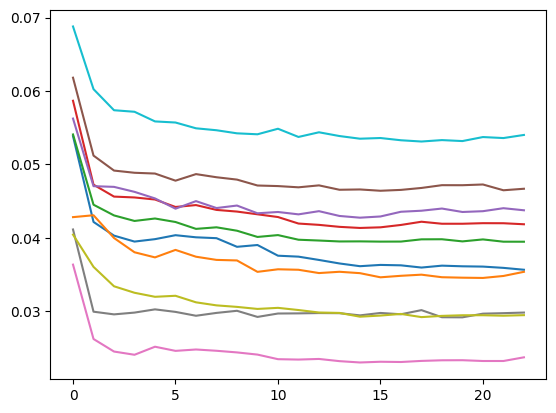

In [289]:
import matplotlib.pyplot as plt
plt.plot(l);